# Analysis of JARVIS-DFT Pre-trained Model: Formation Energy (dHf) Prediction Loss Landscapes

## Overview

This notebook provides a comprehensive analysis of loss landscapes for a pre-trained JARVIS-DFT model designed for formation energy (dHf) prediction. The analysis employs Hessian-based eigenvector decomposition to explore the geometric properties of the optimization landscape and understand model behavior across different crystalline materials.

### Research Objectives
- Characterize the loss landscape geometry for formation energy prediction
- Compare landscape patterns with bandgap prediction models
- Quantify landscape orientation through tilt angle analysis

### Experimental Setup
- **Model**: Pre-trained JARVIS-DFT model for formation energy prediction
- **Dataset**: First 3,000 samples from JARVIS-DFT formation energy dataset
- **Target Property**: Formation energy (dHf) in eV/atom
- **Analysis Method**: Hessian eigenvector-based loss landscape computation
- **Eigenvalue Computation**: Based on 100 samples with lowest prediction error

### Analysis Framework
1. **Data Loading and Integration**: Consolidation of loss landscape and sample metadata
2. **Hessian Eigenvalue Analysis**: Characterization of loss curvature properties
3. **Loss Landscape Visualization**: Geometric analysis of average optimization surface
4. **Dimensionality Reduction**: UMAP-based pattern identification in landscape space
5. **Clustering Analysis**: Identification of distinct landscape groups and patterns
6. **Tilt Angle Analysis**: Quantitative assessment of landscape orientation and deviation

## 1. Environment Setup and Library Imports

### Required Dependencies
Setting up the computational environment with essential libraries for:
- Data manipulation and analysis (pandas, numpy)
- Visualization (matplotlib)
- Machine learning and clustering (scikit-learn, UMAP)
- Custom utilities for loss landscape processing and visualization
- Tilt angle computation for geometric analysis



In [7]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import umap
from util.general import flatten_and_vstack, create_selectors
from util.landscape_processing import restore_to_square_shape
from util.plot import plot_loss_landscape, visualize_image_clusters, plot_categorical_data, plot_numerical_data, plot_umap_parameter_grid, plot_umap_scatter, plot_twin_umap_scatter
import os
from src.tilt_angle import compute_best_tilt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

## 2. Data Loading and Preprocessing

### Loss Landscape Data Import
Loading pre-computed loss landscape data for formation energy prediction analysis. This data contains:

- **Source**: Loss landscapes computed for first 3,000 JARVIS-DFT formation energy samples
- **Computation Method**: Hessian eigenvector analysis based on 100 samples with lowest prediction error
- **Data Structure**: Multi-dimensional arrays representing loss surfaces along principal eigenvector directions
- **Associated Metadata**: Sample identifiers, predictions, errors, and material properties

The loss landscapes for formation energy prediction show distinct characteristics compared to other material properties, with unique geometric patterns that reflect the underlying physics of crystal formation.

In [4]:
folders = [r'computed_loss_landscapes\first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000']

In [5]:
loss_function_dicts = []
for folder in folders:
    with open(os.path.join(folder,'processed_loss_function_dict.pkl'), 'rb') as file:
        loss_function_dicts.append(pickle.load(file))


# Merge all dictionaries from loss_function_dicts into a single dictionary
merged_loss_function_dict = {}
for d in loss_function_dicts:
    for key, value in d.items():
        if key not in merged_loss_function_dict:
            merged_loss_function_dict[key] = value
        else:
            # If key exists, update/append values
            merged_loss_function_dict[key].update(value)

# Update the loss_function_dict to use merged version
loss_function_dict = merged_loss_function_dict

with open(os.path.join(folders[0],'feat_sample_df.pkl'), 'rb') as file:
    feat_sample_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_composition_df.pkl'), 'rb') as file:
    feat_sample_composition_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_structure_df.pkl'), 'rb') as file:
    feat_sample_structure_df = pickle.load(file)

sample_dict = {
    'feat_sample_df': feat_sample_df,
    'feat_sample_composition_df': feat_sample_composition_df,
    'feat_sample_structure_df': feat_sample_structure_df}

combined_dict = {**sample_dict, **loss_function_dict}

all_data_jids = combined_dict['feat_sample_df']['jid'].values


## 3. Hessian Eigenvalue Analysis

### Formation Energy Loss Landscape Curvature
Analyzing the Hessian eigenvalues provides fundamental insights into the local geometry of the loss landscape for formation energy prediction:

- **Maximum Eigenvalue**: 34.3 (steepest curvature direction)
- **Minimum Eigenvalue**: 4.5 (flattest curvature direction)


**Comparison with Bandgap Model**:
- Formation energy landscapes show much lower eigenvalues than bandgap models
- Lower maximum eigenvalue indicates gentler gradients in the steepest direction

This would likely corresponds to the difficulty between predicting formation energy and bandgap.


In [6]:
# Read and extract eigenvalues from file
eigenvalues_path = r'eigenvectors\JVDFT_dHf_lowest_100_error_of_3000\eigenvalues.txt'
with open(eigenvalues_path, 'r') as f:
    eigenvalues_data = f.read()
    
print("Eigenvalues data:")
print(eigenvalues_data)

Eigenvalues data:
Maximum eigenvalue: 4.465170860290527
Minimum eigenvalue: 34.30230712889657
Second maximum eigenvalue: 34.302303314208984



## 4. Average Loss Landscape Visualization

### Formation Energy Optimization Surface Geometry
Visualizing the overall loss landscape by computing the logarithmic average across all 3,000 formation energy samples:

- **Methodology**: Log-scaled mean squared error loss averaged over all samples
- **Coordinate System**: Aligned with Hessian eigenvector directions
- **Axis Interpretation**:
  - θ₁: Direction of maximum curvature (Max Eigenvalue = 34.3)
  - θ₂: Direction of minimum curvature (Min Eigenvalue = 4.5)

**Key Characteristics**:
- Smooth, well-defined minimum indicating stable optimization convergence

This average landscape serves as a baseline for understanding typical formation energy optimization behavior and identifying samples that deviate from this norm.


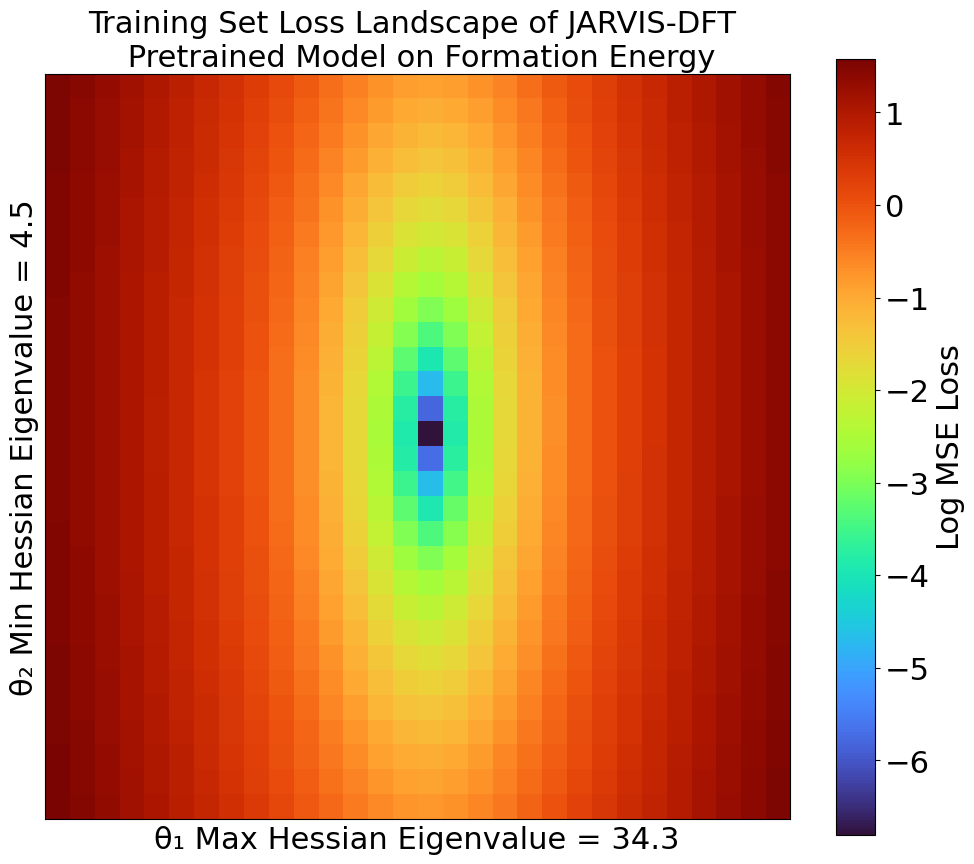

In [8]:
# Plot average loss landscape for all data
idx = np.where(np.isin(all_data_jids, all_data_jids))[0]
arr = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000_mse_loss_landscape_array'].copy()
avg_landscape = np.log(np.mean(arr[idx], axis=0))

# Remove the last dimension to get a 2D array
array_2d = avg_landscape[:, :, 0]

# Plot the image without interpolation
plt.figure(figsize=(10, 10))
plt.imshow(array_2d, cmap='turbo', origin='lower', extent=(-array_2d.shape[0]/2 -0.5, array_2d.shape[0]/2 -0.5, -array_2d.shape[1]/2 -0.5, array_2d.shape[1]/2 -0.5))
cbar = plt.colorbar(label='Log MSE Loss', shrink=0.8)
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Log MSE Loss', fontsize=22)
plt.title(f'Training Set Loss Landscape of JARVIS-DFT \n Pretrained Model on Formation Energy', fontsize=22)
plt.xlabel('θ₁ Max Hessian Eigenvalue = 34.3', fontsize=22)
plt.ylabel('θ₂ Min Hessian Eigenvalue = 4.5', fontsize=22)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


## 5. Dimensionality Reduction Analysis

### UMAP Visualization of Formation Energy Loss Landscapes
Applying UMAP to explore high-dimensional loss landscape patterns and relationships:

- **Methodology**: UMAP transformation of flattened loss landscape arrays
- **Hyperparameters**: n_neighbors=20, min_dist=0.5 optimized for formation energy data
- **Dimensionality**: Reduction from high-dimensional landscape space to 2D visualization
- **Interpretation**: Reveals clusters and patterns specific to formation energy prediction

This dimensionality reduction approach enables identification of materials with similar optimization characteristics and helps uncover hidden relationships between loss landscape geometry and formation energy values.

In [9]:
# Retrieve the selected loss landscape array using the chosen selectors
log_loss_landscape_array = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000_mse_log_loss_landscape_array'].copy()

# Set UMAP hyperparameters for dimensionality reduction
n_neighbors, min_dist = 20, 0.5

# Initialize UMAP with the specified hyperparameters and a fixed random state for reproducibility
umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)

# Apply UMAP to fit and transform the flattened landscape array data
umap_transformed_data = umap_reducer.fit_transform(flatten_and_vstack(log_loss_landscape_array))

c:\Users\EthanH24\anaconda3\envs\ACSURP\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Multi-Modal UMAP Analysis
Examining loss landscapes through different analytical lenses:

1. **Predicted Formation Energy Values**: 
It can be seen that the UMAP technique arranges the loss landscapes such that samples with similar predicted target label are placed together

2. **Z-Score Error Analysis**



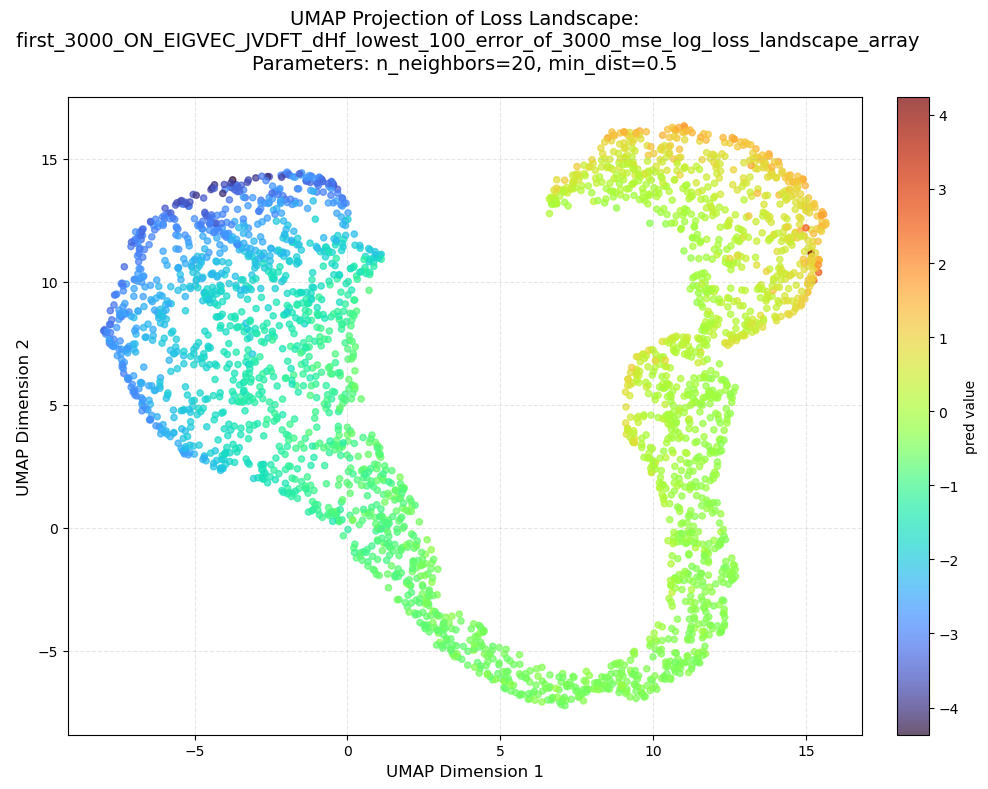

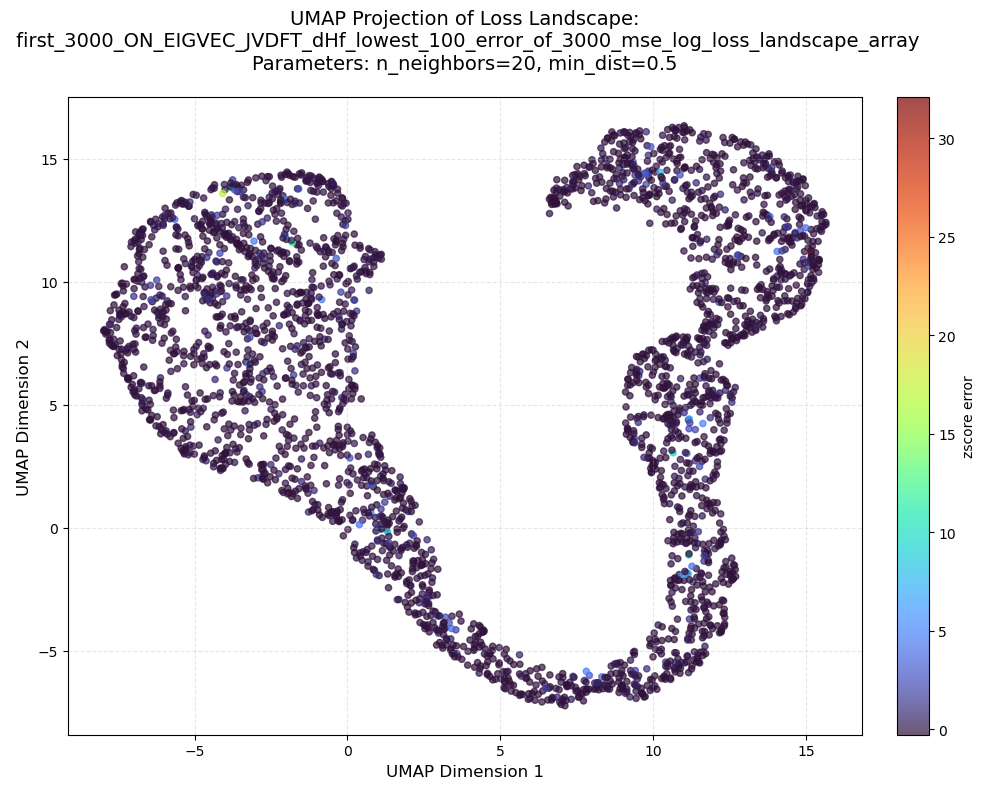

In [10]:
plot_umap_scatter(umap_transformed_data, label_name='pred value',label_type='continuous',labels=combined_dict['feat_sample_df']['pred_val'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)
plot_umap_scatter(umap_transformed_data, label_name='zscore error',label_type='continuous',labels=combined_dict['feat_sample_df']['z_score_err'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)

## 6. Clustering Analysis

### K-means Clustering of Formation Energy Loss Landscapes
Applying unsupervised clustering to identify distinct groups based on loss landscape characteristics:

- **Algorithm**: K-means clustering with 8 clusters for optimal pattern separation
- **Input Data**: Flattened loss landscape arrays from all 3,000 formation energy samples
- **Visualization**: Cluster assignments projected onto UMAP space
- **Purpose**: Group materials with similar optimization surface properties

The clustering analysis reveals that both K-means and UMAP focuses on the tilt angle of the loss landscapes.

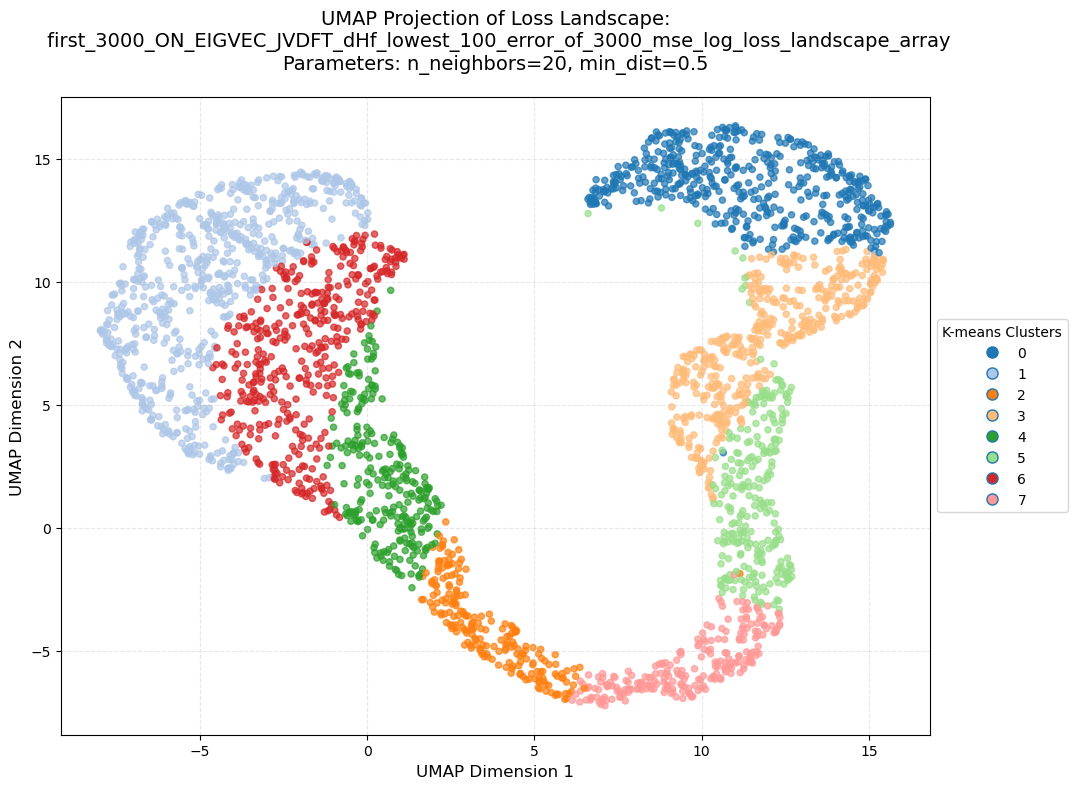

In [11]:
# Initialize and fit K-means clustering with the specified number of clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(flatten_and_vstack(log_loss_landscape_array))
# Retrieve the cluster labels from the fitted K-means model
k_means_labels = kmeans.labels_
plot_umap_scatter(umap_transformed_data, labels=k_means_labels, label_name='K-means Clusters', label_type='categorical', n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)

### Cluster-wise Loss Landscape Examination
Detailed visualization of representative loss landscapes from each identified cluster:

- **Display Strategy**: Up to 20 landscapes per cluster for pattern recognition
- **Geometric Analysis**: Identification of common features within each cluster
- **Pattern Validation**: Verification of clustering quality through visual inspection
- **Characteristic Identification**: Understanding what defines each cluster's landscape geometry

This detailed examination reveals the specific geometric patterns that distinguish different groups of formation energy materials and validates the clustering approach.

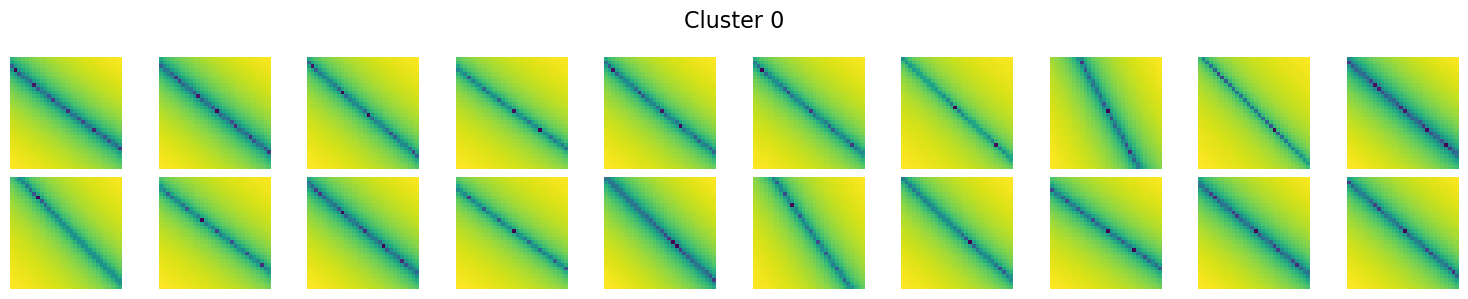

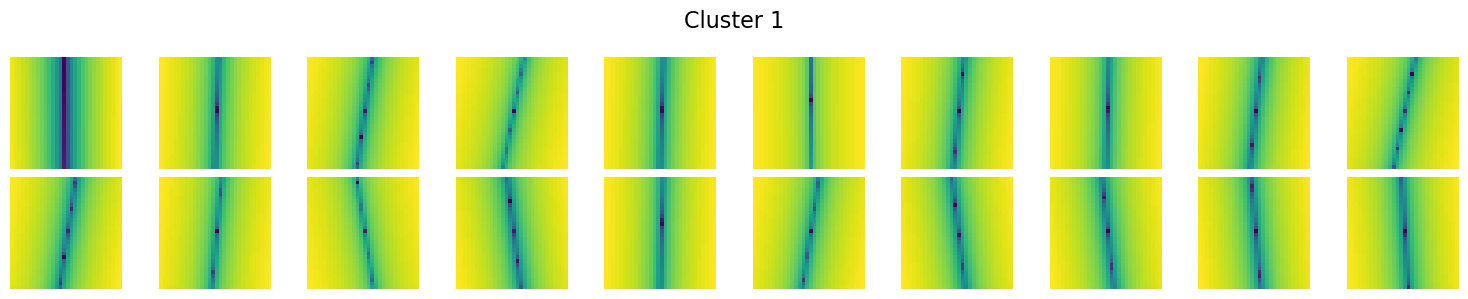

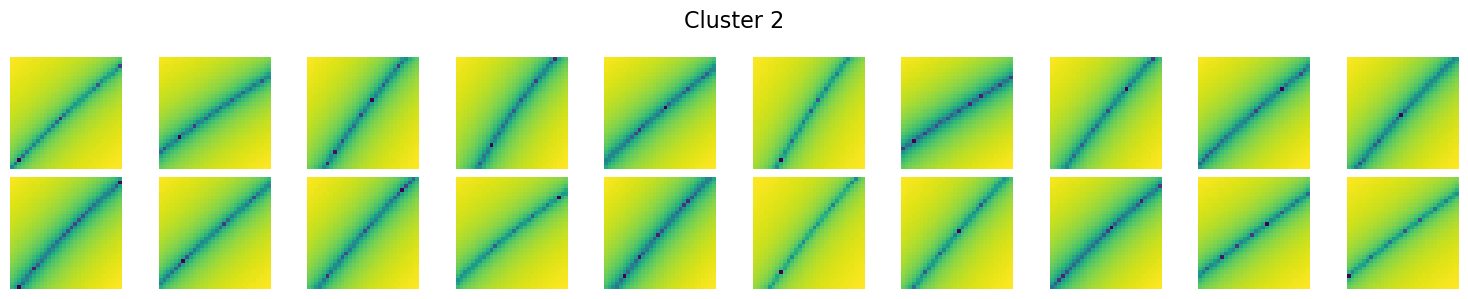

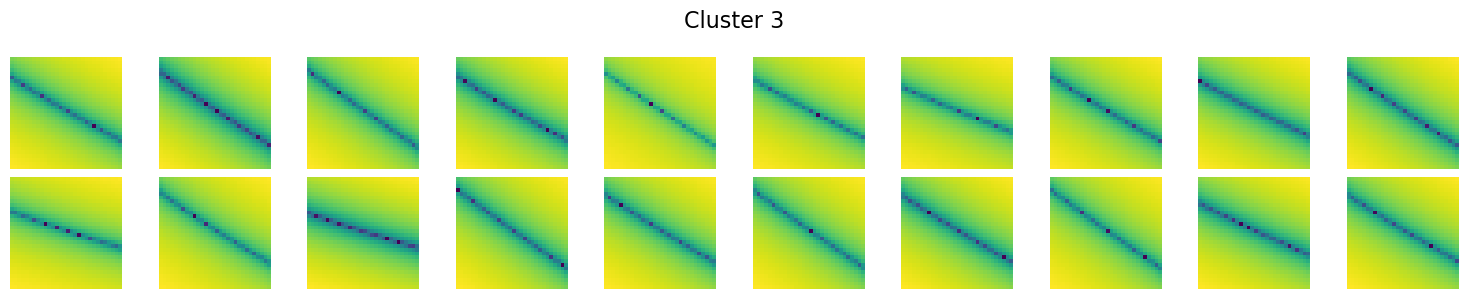

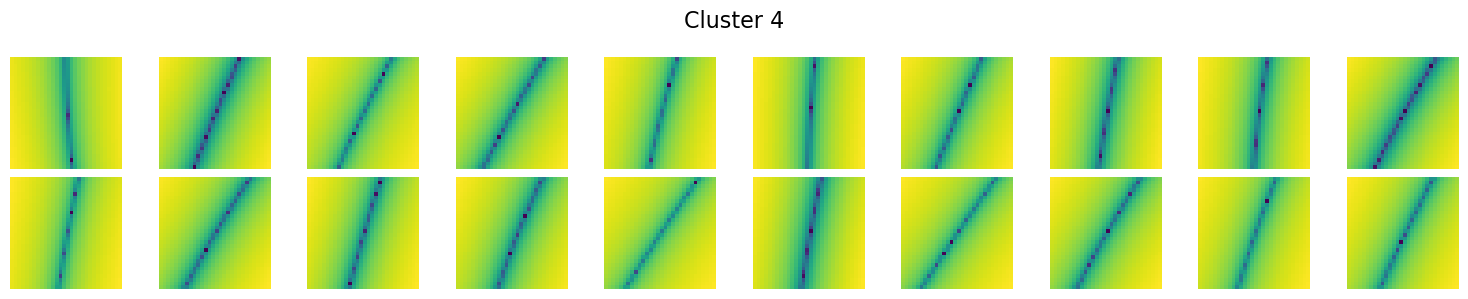

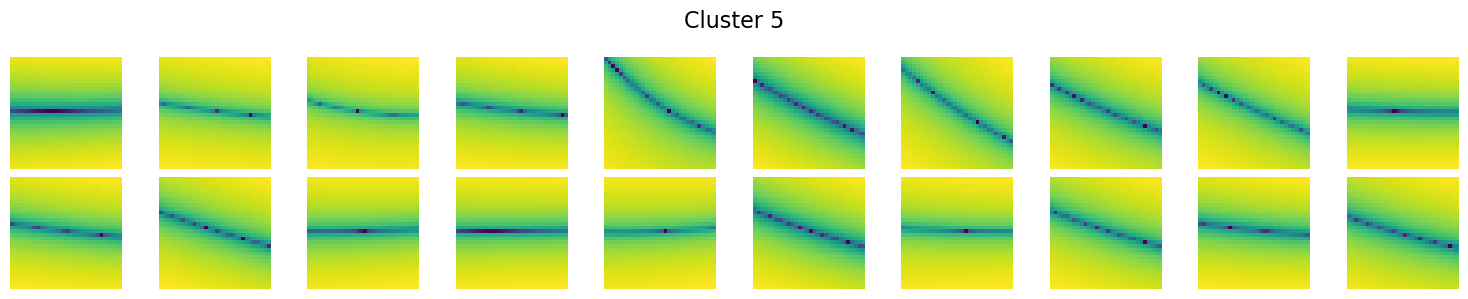

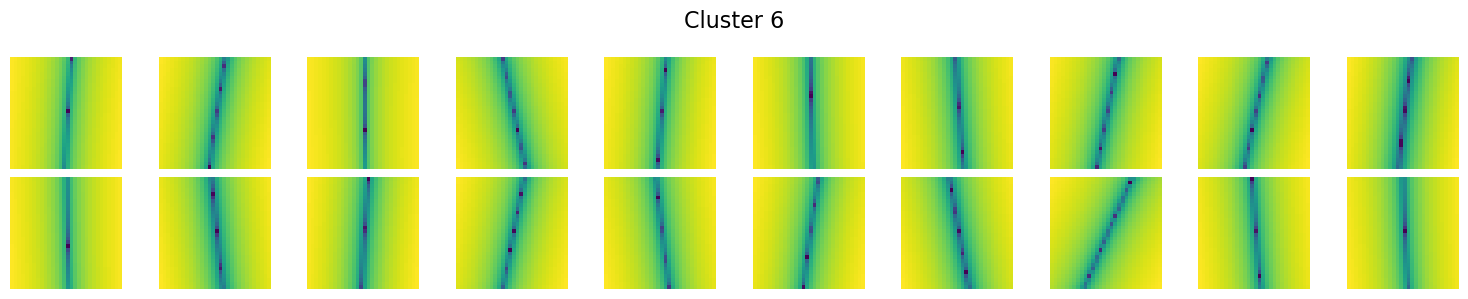

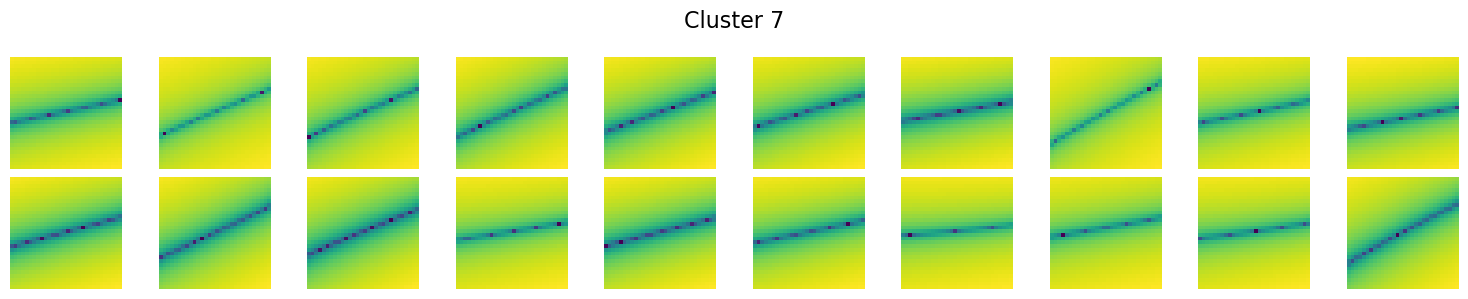

In [12]:
visualize_image_clusters(log_loss_landscape_array, k_means_labels,max_arrays_per_cluster=20)

## 7. Key Observations: Unique Formation Energy Landscape Characteristics


#### Curved vs Linear Patterns
- **Formation Energy**: Some loss landscapes show curved contour lines rather than straight linear patterns

#### Rotational Behavior
- **Angular Range**: Landscapes can rotate up to approximately 135 degrees from the standard orientation

#### Horizontal Landscape Samples
- **Unique Geometry**: Some samples exhibit predominantly horizontal loss landscape orientations, which means that the sample's dominant Hessian eigenvector are orthogonal to the 100 subset's aggregate Hessian eigenvector.


## 8. Tilt Angle Analysis

### Quantitative Assessment of Formation Energy Landscape Orientation
Computing tilt angles to quantify the directional characteristics observed in the formation energy loss landscapes:

- **Methodology**: Best-fit tilt angle computation for each sample's loss landscape
- **Angle Measurement Modes**:
  - **Signed 90°**: Captures directional information with quadrant sensitivity
  - **Unsigned 180°**: Measures absolute tilt magnitude regardless of direction
- **Formation Energy Context**: Tilt angles may correlate with thermodynamic stability or structural factors
- **Comparative Analysis**: Relationship between landscape orientation and predicted formation energy values

This quantitative approach provides systematic characterization of the rotational behavior observed qualitatively and enables statistical analysis of orientation patterns across the dataset.

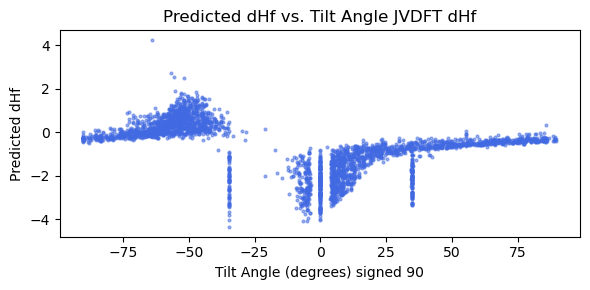

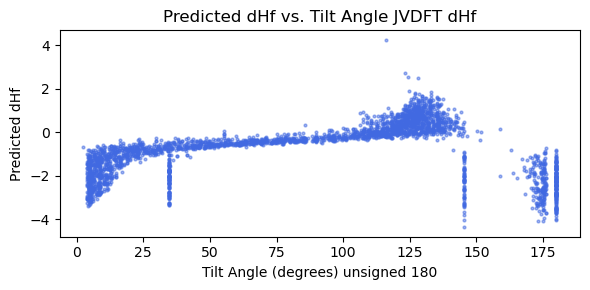

In [ ]:
log_loss_landscape_array = loss_function_dict['first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000_mse']['first_3000_ON_EIGVEC_JVDFT_dHf_lowest_100_error_of_3000_mse_log_loss_landscape_array'].copy()

angles_signed90 = []
for i in range(len(log_loss_landscape_array.to_list())):
    angle, _ = compute_best_tilt(log_loss_landscape_array.to_list()[i], degrees=True,angle_mode='signed90', fit_mode=None)
    angles_signed90.append(angle)

angles_unsigned180 = []
for i in range(len(log_loss_landscape_array.to_list())):
    angle, _ = compute_best_tilt(log_loss_landscape_array.to_list()[i], degrees=True,angle_mode='unsigned180', fit_mode=None)
    angles_unsigned180.append(angle)


# Plot predicted values as a function of tilt angle
pred_vals = combined_dict['feat_sample_df']['pred_val']

# Add a vertical line at x=0 and a horizontal line at y=-1 to the previous plot
plt.figure(figsize=(6,3))
plt.scatter(angles_signed90, pred_vals, alpha=0.5, color='royalblue', edgecolor= None, s=4)
plt.xlabel('Tilt Angle (degrees) signed 90')
plt.ylabel('Predicted dHf')
plt.title('Predicted dHf vs. Tilt Angle JVDFT dHf')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.scatter(angles_unsigned180, pred_vals, alpha=0.5, color='royalblue', edgecolor= None, s=4)
plt.xlabel('Tilt Angle (degrees) unsigned 180')
plt.ylabel('Predicted dHf')
plt.title('Predicted dHf vs. Tilt Angle JVDFT dHf')
plt.tight_layout()
plt.show()
